In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [46]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

### Loading the connectivity table for the post-processing

In [55]:
connectivity = pd.read_pickle('connectivity_table_maupiti')

# Loading the maps

In [ ]:
augmented[5:-5, 5:-5] = band

    augmented[:5, 5:-5] = np.flipud(band[:5, :])
    augmented[-5:, 5:-5] = np.flipud(band[-5:, :])
    augmented[5:-5, :5] = np.fliplr(band[:, :5])
    augmented[5:-5, -5:] = np.fliplr(band[:, -5:])

    augmented[:5, :5] = np.flip(band[:5, :5])
    augmented[-5:, :5] = np.flip(band[-5:, :5])
    augmented[:5, -5:] = np.flip(band[:5, -5:])
    augmented[-5:, -5:] = np.flip(band[-5:, -5:])

In [47]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_10m.npy')
pleiades_img = np.load('../v2/data/pleiades_ortho_10m.npy')

In [56]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

In [57]:
map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=3)

In [58]:
classified_pixels = np.where(img_rugo_zones>0)

In [59]:
random.seed(0)
size_subset = 250000
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

In [60]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970405
Wall time: 1min 31s


In [61]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 12.4 s


In [62]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
print(score_pb)

0.9095832802344845


In [52]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
print(score_pb)

0.9093921243787435


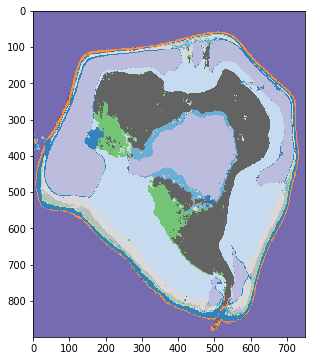

In [51]:
plt.figure(figsize=(6,6))
plt.imshow(predicted_map_pixelbased_rf_classes, interpolation='None', cmap='tab20c_r')
plt.show()

In [28]:
map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=20)

In [29]:
map_test.smooth_pb_rf()

In [30]:
map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1

In [31]:
smooth_map = np.copy(map_test.smoothed_map_pb_rf)

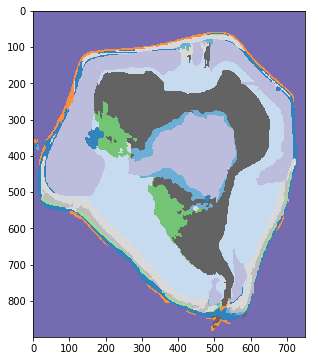

In [50]:
plt.figure(figsize=(6,6))
plt.imshow(smooth_map, interpolation='None', cmap='tab20c_r')
plt.show()

In [33]:
score_map_smooth = score_map(img_rugo_zones, smooth_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
print(score_map_smooth)

0.8724990442207213


# Post processing

In [34]:
list_scores_post_processing = []
list_thresholds_post_processing = []

In [35]:
predicted_map_pixelbased_rf_classes = np.load('data/prediction_pb_10m.npy')
smooth_map = np.load('data/smooth_map_10m.npy')

In [10]:
import segments_regressor
from skimage.segmentation import find_boundaries

In [11]:
segments_classes = np.copy(map_test.y_segments_pb_rf_classes)
segments_classes

AttributeError: 'coral_map' object has no attribute 'y_segments_pb_rf_classes'

In [38]:
boundaries = find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [39]:
%%time
list_wrong_neighbours = []
for i in range(len(adjacent_segments)):
    wrong_neighbours = 0
    s = adjacent_segments[i]
    s_class = segments_classes[i]
    if s_class > 0:
        s_connectivity = connectivity[s_class]
        for j in s:
            if segments_classes[j]>0:
                if s_connectivity[segments_classes[j]] == 0 :
                    wrong_neighbours += 1
    list_wrong_neighbours.append(wrong_neighbours/len(s))

Wall time: 150 ms


In [40]:
threshold = 0.8
nb_wrong_segments=0
for i, value in enumerate(list_wrong_neighbours):
    if value>0:
        #assign the majority of neighbours to this segment
        nb_wrong_segments+=1
        lst_temp = [segments_classes[j] for j in adjacent_segments[i]]
        majority_neighbours = max(set(lst_temp), key=lst_temp.count)
        if majority_neighbours/len(lst_temp) > threshold:
            segments_classes[i] = majority_neighbours
print(nb_wrong_segments)

552


In [43]:
new_map = np.copy(map_test.segments)
for i in range(np.max(map_test.segments)+1):
    new_map[map_test.segments==i] = segments_classes[i]+1

In [47]:
score_pp = score_map(img_rugo_zones,new_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
score_pp

0.873900853829489

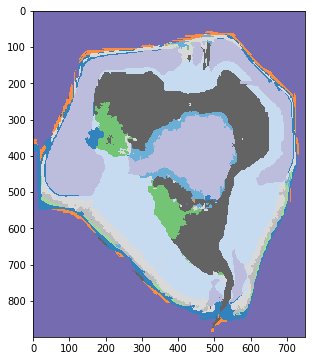

In [49]:
plt.figure(figsize=(6,6))
plt.imshow(new_map, interpolation='None', cmap='tab20c_r')
plt.show()

# Summary of the performances

In [56]:
print('Score of the pixel-based map:', np.round(score_pb, 4))
print('Score of the smoothed map:', np.round(score_map_smooth,4))
print('Score of the post-processed map:', np.round(score_pp,4))

Score of the pixel-based map: 0.9094
Score of the smoothed map: 0.8725
Score of the post-processed map: 0.8739


# Repeat it 10 times

In [63]:
%%time
scores_pb = []
scores_smooth = []
scores_pp = []
for i in range(10):
    map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=3)
    random.seed(i)
    
    random_train_test = random.sample(index_combination,size_subset)
    training_set_indexes_pb = random_train_test[:size_subset//5]
    testing_set_indexes_pb = random_train_test[size_subset//5:]

    map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

    map_test.predict_map_pixelbased_rf()

    predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
    score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
    
    #smoothing
    map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=20)
    map_test.smooth_pb_rf()
    map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1
    smooth_map = np.copy(map_test.smoothed_map_pb_rf)
    score_map_smooth = score_map(img_rugo_zones, smooth_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
    
    #post-processing
    segments_classes = np.copy(map_test.y_segments_pb_rf_classes)
    boundaries = find_boundaries(map_test.segments)
    adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

    list_wrong_neighbours = []
    for i in range(len(adjacent_segments)):
        wrong_neighbours = 0
        s = adjacent_segments[i]
        s_class = segments_classes[i]
        if s_class > 0:
            s_connectivity = connectivity[s_class]
            for j in s:
                if segments_classes[j]>0:
                    if s_connectivity[segments_classes[j]] == 0 :
                        wrong_neighbours += 1
        list_wrong_neighbours.append(wrong_neighbours/len(s))

    threshold = 0.8
    nb_wrong_segments=0
    for i, value in enumerate(list_wrong_neighbours):
        if value>0:
            #assign the majority of neighbours to this segment
            nb_wrong_segments+=1
            lst_temp = [segments_classes[j] for j in adjacent_segments[i]]
            majority_neighbours = max(set(lst_temp), key=lst_temp.count)
            if majority_neighbours/len(lst_temp) > threshold:
                segments_classes[i] = majority_neighbours

    new_map = np.copy(map_test.segments)
    for i in range(np.max(map_test.segments)+1):
        new_map[map_test.segments==i] = segments_classes[i]+1

    score_pp = score_map(img_rugo_zones,new_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=3)
    
    scores_pb.append(score_pb)
    scores_smooth.append(score_map_smooth)
    scores_pp.append(score_pp)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970625


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97048


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970725


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970995


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97104


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97072


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97031


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970735


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.97046


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)
C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:106: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.970025


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:56: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


Wall time: 18min 9s


In [64]:
print(np.round(np.mean(scores_pb),4), np.round(np.std(scores_pb),4))
print(np.round(np.mean(scores_smooth),4), np.round(np.std(scores_smooth),4))
print(np.round(np.mean(scores_pp),4), np.round(np.std(scores_pp),4))

0.9072 0.0049
0.8689 0.0057
0.8696 0.0051
